In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os

os.chdir('/content/drive/MyDrive/Seed_Classification_4_varieties/crease_up_down_combined')
os.getcwd()

'/content/drive/MyDrive/Seed_Classification_4_varieties/crease_up_down_combined'

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as oversample
from model import *
from train_eval import *
import torch
from torchsummary import summary
import torch.optim as optim
import pickle
from sklearn.metrics import confusion_matrix, classification_report


In [23]:
# re-structuring data for training machine-learning model
# combining (train, validation) then applying balancing techniques

if not os.path.exists('Data/combined_df_tr_imbalanced.csv'):

    df_tr = pd.read_csv('Data/df_tr_imbalanced.csv')
    df_val = pd.read_csv('Data/df_val.csv')

    df_train = pd.concat([df_tr, df_val], axis=0)
    df_train = df_train.reset_index(drop=True)
    df_train.to_csv(f'Data/combined_df_tr_imbalanced.csv', index=False)
    print(df_train.shape)

    # apply smote
    X, y = df_train.iloc[:, :-1], df_train.iloc[: , -1]


    # applying smote
    oversampler = oversample.SMOTE()
    X_smote, Y_smote = oversampler.fit_resample(X, y)

    df_tr_smote = pd.concat([X_smote, Y_smote], axis=1)
    df_tr_smote.to_csv('Data/combined_df_tr_smote.csv')

    # applying Adasyn
    oversampler = oversample.ADASYN()
    X_adasyn, Y_adasyn = oversampler.fit_resample(X, y)

    df_tr_adasyn = pd.concat([X_adasyn, Y_adasyn], axis=1)
    df_tr_adasyn.to_csv('Data/combined_df_tr_adasyn.csv')


## Data-Processing

In [24]:
if not os.path.exists('Data/df_tr_smote.csv'):
  df_tr_imbalanced = pd.read_csv('Data/df_tr_imbalanced.csv')
  X, y = df_tr_imbalanced.iloc[:, :-1], df_tr_imbalanced.iloc[: , -1]
  print(df_tr_imbalanced.shape , X.shape , y.shape)

  # applying smote
  oversampler = oversample.SMOTE()
  X_smote, Y_smote = oversampler.fit_resample(X, y)

  df_tr_smote = pd.concat([X_smote, Y_smote], axis=1)
  print(df_tr_smote.shape, X_smote.shape, Y_smote.shape)
  df_tr_smote.to_csv('Data/df_tr_smote.csv', index = False)

  # applying Adasyn
  oversampler = oversample.ADASYN()
  X_adasyn, Y_adasyn = oversampler.fit_resample(X, y)

  df_tr_adasyn = pd.concat([X_adasyn, Y_adasyn], axis=1)
  df_tr_adasyn.to_csv('Data/df_tr_adasyn.csv', index= False)

  print('Imbalanced : ', df_tr_imbalanced.shape)
  print('Smote balanced : ', df_tr_smote.shape)
  print('Adasyn balanced : ', df_tr_adasyn.shape)

In [25]:
config = {
    'BATCH_SIZE' : 32,
    'lr' : 0.00005,
    'EPOCHS' : 50,
    'input_size' : 294,
    'output_size' : 4,

    'val_path' : 'Data/df_val.csv',
    'tst_path' : 'Data/df_tst.csv' ,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_tst = pd.read_csv(config['tst_path'])

## Setting Training

In [26]:
model = CNN1D(config['output_size']).to(device)
summary(model, (config['input_size'],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1               [-1, 1, 294]               2
            Conv1d-2              [-1, 32, 292]             128
             PReLU-3              [-1, 32, 292]               1
         MaxPool1d-4              [-1, 32, 146]               0
           Conv_1D-5              [-1, 32, 146]               0
       BatchNorm1d-6              [-1, 32, 146]              64
            Conv1d-7               [-1, 64, 71]          10,304
             PReLU-8               [-1, 64, 71]               1
         MaxPool1d-9               [-1, 64, 35]               0
          Conv_1D-10               [-1, 64, 35]               0
      BatchNorm1d-11               [-1, 64, 35]             128
           Conv1d-12              [-1, 128, 16]          41,088
            PReLU-13              [-1, 128, 16]               1
        MaxPool1d-14               [-1,

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.CrossEntropyLoss()    # weight = class_weights.to(device)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5,cooldown= 2, factor = 0.4, verbose = True, threshold = 1e-2)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Plotting

In [28]:
def plot_history(history:dict, model_name):
      plt.figure( figsize=(20,10))

    #   plt.subplot(2, 1, 1)
      plt.plot(history['train_loss'], 'o-', color='green')
      plt.plot(history['val_loss'], 'o-', color='red')
      plt.plot(history['train_acc'], 'o-', color='pink')
      plt.plot(history['val_acc'], 'o-', color='blue')
    #   plt.ylabel('Loss')
      plt.xlabel('Epochs', fontsize = 14)
      plt.legend(['Train Loss' , 'Validation Loss','Train Accuracy' , 'Validation Accuracy'],  fontsize = 14)


      plt.savefig('{x}_Train_Val_Curves.png'.format(x = model_name), bbox_inches='tight')


## Imbalanced Data Training

In [29]:
config['tr_path'] = 'Data/df_tr_imbalanced.csv'
config['name'] = 'imbalanced'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([294]) torch.Size([294])


In [30]:
if not os.path.exists('imbalanced_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


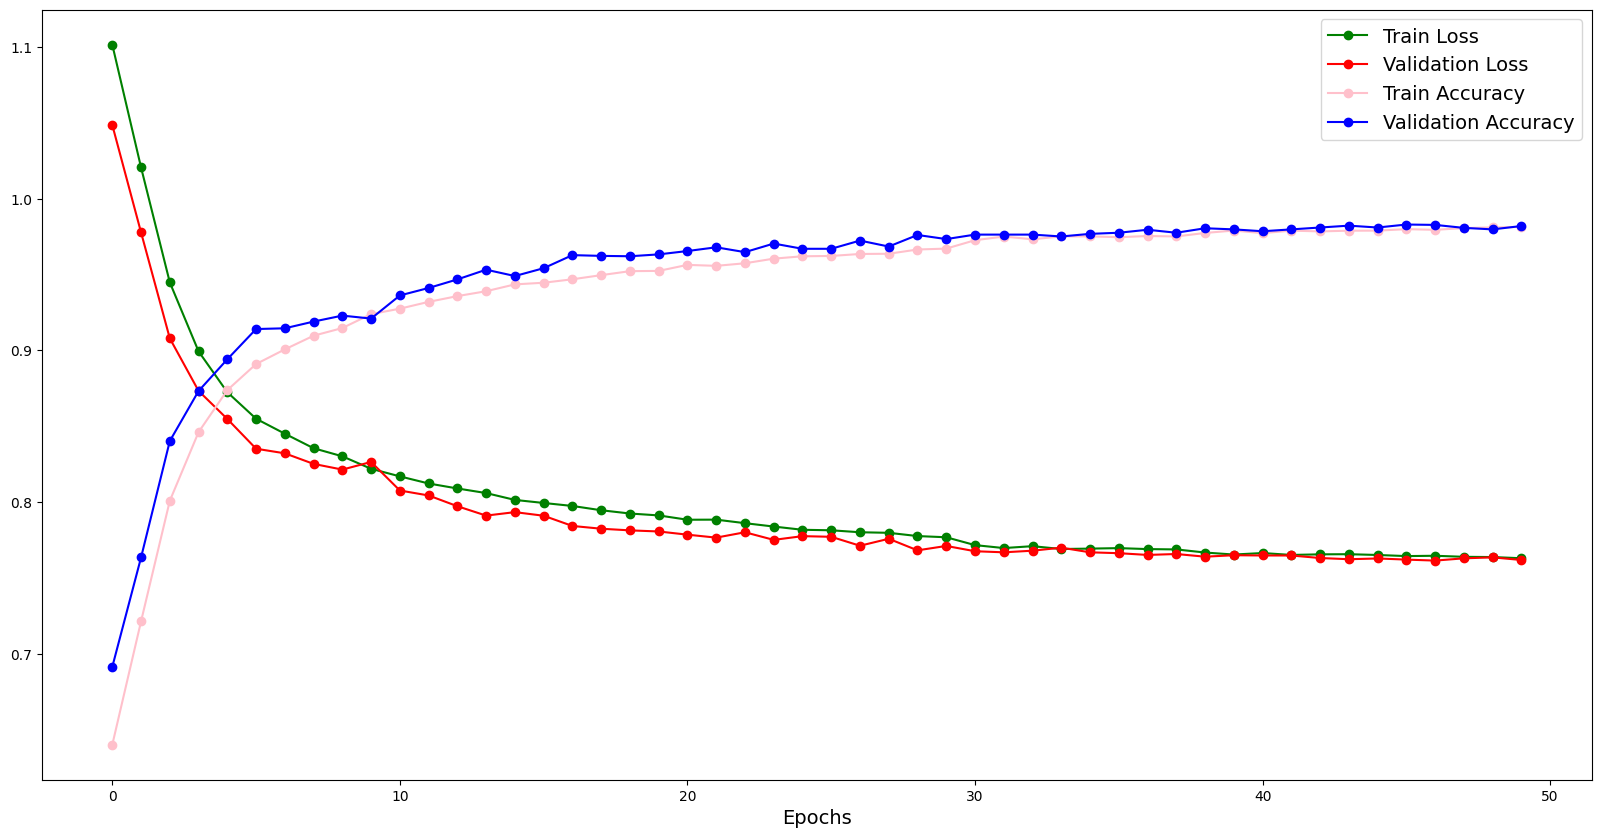

In [31]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [32]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3030
         1.0       0.99      0.97      0.98      3030
         2.0       0.99      0.99      0.99      1414
         3.0       0.94      0.97      0.95       606

    accuracy                           0.98      8080
   macro avg       0.97      0.98      0.98      8080
weighted avg       0.98      0.98      0.98      8080



## SMOTE-Balanced Training

In [33]:
config['tr_path'] = 'Data/df_tr_smote.csv'
config['name'] = 'smote'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([294]) torch.Size([294])


In [34]:
if not os.path.exists('smote_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


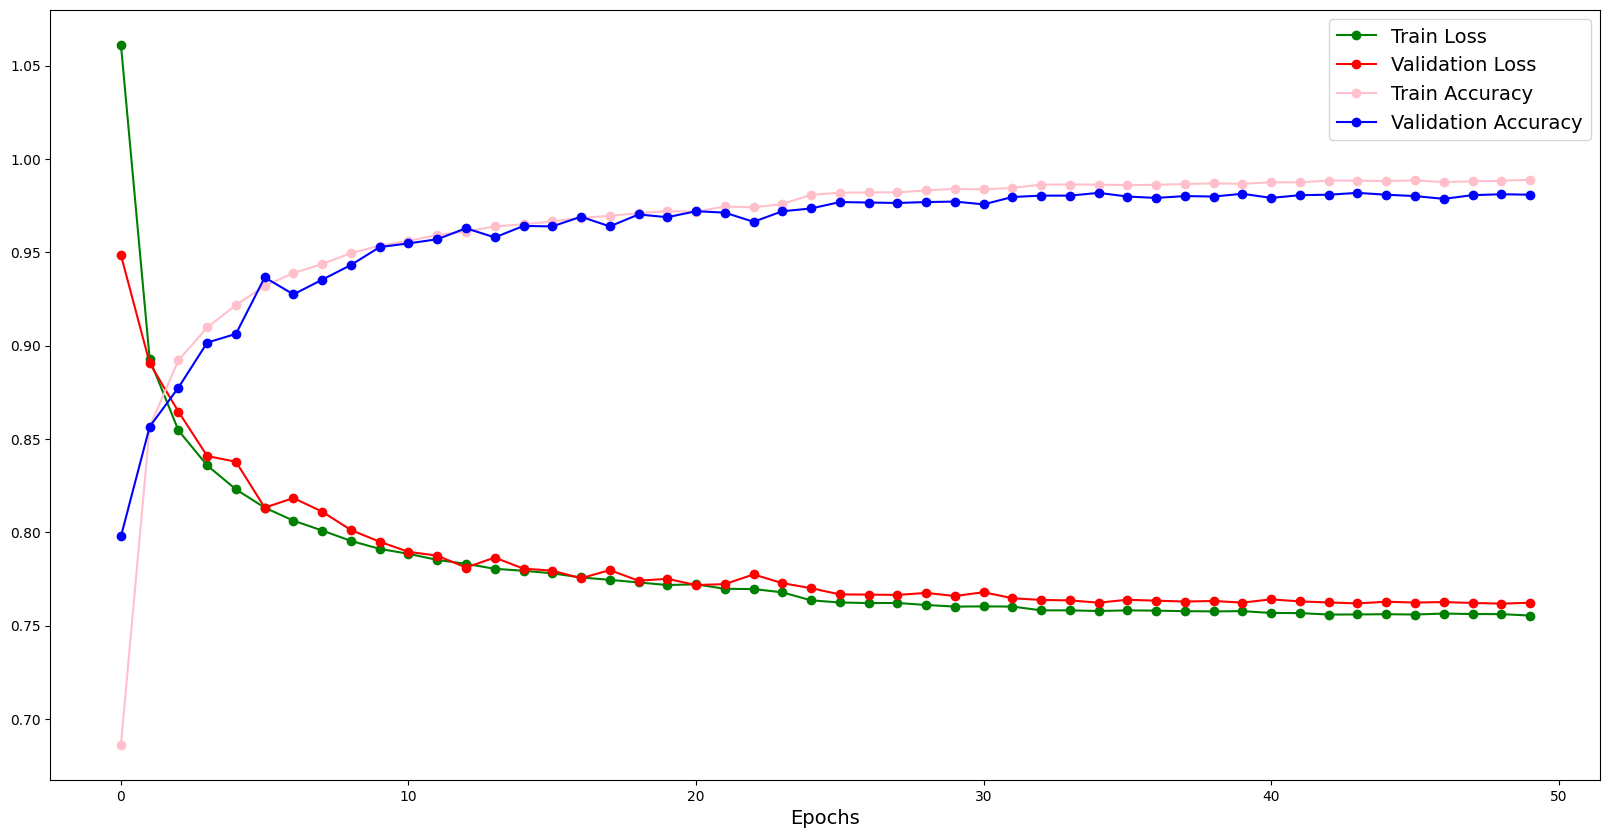

In [35]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [36]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3030
         1.0       0.99      0.97      0.98      3030
         2.0       0.99      0.99      0.99      1414
         3.0       0.95      0.97      0.96       606

    accuracy                           0.98      8080
   macro avg       0.98      0.98      0.98      8080
weighted avg       0.98      0.98      0.98      8080



## Adasyn-Data Training

In [37]:
config['tr_path'] = 'Data/df_tr_adasyn.csv'
config['name'] = 'adasyn'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([294]) torch.Size([294])


In [38]:
if not os.path.exists('adasyn_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


torch.Size([32, 294]) torch.Size([32])

Epoch: 0


100%|██████████| 127/127 [00:00<00:00, 433.11it/s]


Epoch [0] --> LossTr: 1.0590    AccTr: 0.6895    lossVal : 0.9299     accVal : 0.8216

Detected network improvement, saving current model  "✅"

Epoch: 1


100%|██████████| 127/127 [00:00<00:00, 438.04it/s]


Epoch [1] --> LossTr: 0.8800    AccTr: 0.8696    lossVal : 0.8875     accVal : 0.8563

Detected network improvement, saving current model  "✅"

Epoch: 2


100%|██████████| 127/127 [00:00<00:00, 417.52it/s]


Epoch [2] --> LossTr: 0.8453    AccTr: 0.9001    lossVal : 0.8535     accVal : 0.8947

Detected network improvement, saving current model  "✅"

Epoch: 3


100%|██████████| 127/127 [00:00<00:00, 411.15it/s]


Epoch [3] --> LossTr: 0.8272    AccTr: 0.9187    lossVal : 0.8474     accVal : 0.8947


Epoch: 4


100%|██████████| 127/127 [00:00<00:00, 306.27it/s]


Epoch [4] --> LossTr: 0.8161    AccTr: 0.9289    lossVal : 0.8318     accVal : 0.9104

Detected network improvement, saving current model  "✅"

Epoch: 5


100%|██████████| 127/127 [00:00<00:00, 394.48it/s]


Epoch [5] --> LossTr: 0.8056    AccTr: 0.9401    lossVal : 0.8112     accVal : 0.9331

Detected network improvement, saving current model  "✅"

Epoch: 6


100%|██████████| 127/127 [00:00<00:00, 432.27it/s]


Epoch [6] --> LossTr: 0.7997    AccTr: 0.9453    lossVal : 0.8095     accVal : 0.9338


Epoch: 7


100%|██████████| 127/127 [00:00<00:00, 304.44it/s]


Epoch [7] --> LossTr: 0.7940    AccTr: 0.9509    lossVal : 0.7954     accVal : 0.9473

Detected network improvement, saving current model  "✅"

Epoch: 8


100%|██████████| 127/127 [00:00<00:00, 434.32it/s]


Epoch [8] --> LossTr: 0.7889    AccTr: 0.9566    lossVal : 0.7964     accVal : 0.9483


Epoch: 9


100%|██████████| 127/127 [00:00<00:00, 454.34it/s]


Epoch [9] --> LossTr: 0.7865    AccTr: 0.9581    lossVal : 0.7918     accVal : 0.9528


Epoch: 10


100%|██████████| 127/127 [00:00<00:00, 319.50it/s]


Epoch [10] --> LossTr: 0.7825    AccTr: 0.9626    lossVal : 0.7863     accVal : 0.9579


Epoch: 11


100%|██████████| 127/127 [00:00<00:00, 449.54it/s]


Epoch [11] --> LossTr: 0.7789    AccTr: 0.9652    lossVal : 0.7846     accVal : 0.9596

Detected network improvement, saving current model  "✅"

Epoch: 12


100%|██████████| 127/127 [00:00<00:00, 455.65it/s]


Epoch [12] --> LossTr: 0.7778    AccTr: 0.9664    lossVal : 0.7788     accVal : 0.9653


Epoch: 13


100%|██████████| 127/127 [00:00<00:00, 279.00it/s]


Epoch [13] --> LossTr: 0.7761    AccTr: 0.9682    lossVal : 0.7767     accVal : 0.9692


Epoch: 14


100%|██████████| 127/127 [00:00<00:00, 435.70it/s]


Epoch [14] --> LossTr: 0.7744    AccTr: 0.9698    lossVal : 0.7770     accVal : 0.9668


Epoch: 15


100%|██████████| 127/127 [00:00<00:00, 421.53it/s]


Epoch [15] --> LossTr: 0.7725    AccTr: 0.9714    lossVal : 0.7777     accVal : 0.9656


Epoch: 16


100%|██████████| 127/127 [00:00<00:00, 313.50it/s]


Epoch [16] --> LossTr: 0.7711    AccTr: 0.9730    lossVal : 0.7694     accVal : 0.9749

Detected network improvement, saving current model  "✅"

Epoch: 17


100%|██████████| 127/127 [00:00<00:00, 417.11it/s]


Epoch [17] --> LossTr: 0.7694    AccTr: 0.9751    lossVal : 0.7737     accVal : 0.9697


Epoch: 18


100%|██████████| 127/127 [00:00<00:00, 442.62it/s]


Epoch [18] --> LossTr: 0.7689    AccTr: 0.9751    lossVal : 0.7659     accVal : 0.9779


Epoch: 19


100%|██████████| 127/127 [00:00<00:00, 285.46it/s]


Epoch [19] --> LossTr: 0.7686    AccTr: 0.9752    lossVal : 0.7710     accVal : 0.9719


Epoch: 20


100%|██████████| 127/127 [00:00<00:00, 430.76it/s]


Epoch [20] --> LossTr: 0.7661    AccTr: 0.9785    lossVal : 0.7699     accVal : 0.9739


Epoch: 21


100%|██████████| 127/127 [00:00<00:00, 417.86it/s]


Epoch [21] --> LossTr: 0.7651    AccTr: 0.9787    lossVal : 0.7730     accVal : 0.9705


Epoch: 22


100%|██████████| 127/127 [00:00<00:00, 281.01it/s]


Epoch [22] --> LossTr: 0.7653    AccTr: 0.9785    lossVal : 0.7658     accVal : 0.9781


Epoch: 23


100%|██████████| 127/127 [00:00<00:00, 427.83it/s]


Epoch [23] --> LossTr: 0.7639    AccTr: 0.9799    lossVal : 0.7658     accVal : 0.9781


Epoch: 24


100%|██████████| 127/127 [00:00<00:00, 429.80it/s]


Epoch [24] --> LossTr: 0.7628    AccTr: 0.9813    lossVal : 0.7657     accVal : 0.9769


Epoch: 25


100%|██████████| 127/127 [00:00<00:00, 291.68it/s]


Epoch [25] --> LossTr: 0.7625    AccTr: 0.9815    lossVal : 0.7746     accVal : 0.9688


Epoch: 26


100%|██████████| 127/127 [00:00<00:00, 424.01it/s]


Epoch [26] --> LossTr: 0.7615    AccTr: 0.9822    lossVal : 0.7634     accVal : 0.9798


Epoch: 27


100%|██████████| 127/127 [00:00<00:00, 424.33it/s]


Epoch [27] --> LossTr: 0.7579    AccTr: 0.9857    lossVal : 0.7616     accVal : 0.9811


Epoch: 28


100%|██████████| 127/127 [00:00<00:00, 428.54it/s]


Epoch [28] --> LossTr: 0.7563    AccTr: 0.9877    lossVal : 0.7611     accVal : 0.9825


Epoch: 29


100%|██████████| 127/127 [00:00<00:00, 414.54it/s]


Epoch [29] --> LossTr: 0.7567    AccTr: 0.9870    lossVal : 0.7599     accVal : 0.9847


Epoch: 30


100%|██████████| 127/127 [00:00<00:00, 436.34it/s]


Epoch [30] --> LossTr: 0.7561    AccTr: 0.9879    lossVal : 0.7580     accVal : 0.9857

Detected network improvement, saving current model  "✅"

Epoch: 31


100%|██████████| 127/127 [00:00<00:00, 433.58it/s]


Epoch [31] --> LossTr: 0.7562    AccTr: 0.9879    lossVal : 0.7619     accVal : 0.9823


Epoch: 32


100%|██████████| 127/127 [00:00<00:00, 438.23it/s]


Epoch [32] --> LossTr: 0.7554    AccTr: 0.9890    lossVal : 0.7605     accVal : 0.9835


Epoch: 33


100%|██████████| 127/127 [00:00<00:00, 409.72it/s]


Epoch [33] --> LossTr: 0.7549    AccTr: 0.9890    lossVal : 0.7584     accVal : 0.9865


Epoch: 34


100%|██████████| 127/127 [00:00<00:00, 412.51it/s]


Epoch [34] --> LossTr: 0.7552    AccTr: 0.9888    lossVal : 0.7571     accVal : 0.9872


Epoch: 35


100%|██████████| 127/127 [00:00<00:00, 415.45it/s]


Epoch [35] --> LossTr: 0.7541    AccTr: 0.9897    lossVal : 0.7572     accVal : 0.9875


Epoch: 36


100%|██████████| 127/127 [00:00<00:00, 430.04it/s]


Epoch [36] --> LossTr: 0.7537    AccTr: 0.9903    lossVal : 0.7573     accVal : 0.9865


Epoch: 37


100%|██████████| 127/127 [00:00<00:00, 435.70it/s]


Epoch [37] --> LossTr: 0.7540    AccTr: 0.9900    lossVal : 0.7572     accVal : 0.9867


Epoch: 38


100%|██████████| 127/127 [00:00<00:00, 442.48it/s]


Epoch [38] --> LossTr: 0.7532    AccTr: 0.9908    lossVal : 0.7598     accVal : 0.9833


Epoch: 39


100%|██████████| 127/127 [00:00<00:00, 421.03it/s]


Epoch [39] --> LossTr: 0.7535    AccTr: 0.9904    lossVal : 0.7570     accVal : 0.9867


Epoch: 40


100%|██████████| 127/127 [00:00<00:00, 433.67it/s]


Epoch [40] --> LossTr: 0.7528    AccTr: 0.9915    lossVal : 0.7591     accVal : 0.9847


Epoch: 41


100%|██████████| 127/127 [00:00<00:00, 352.16it/s]


Epoch [41] --> LossTr: 0.7525    AccTr: 0.9918    lossVal : 0.7571     accVal : 0.9865


Epoch: 42


100%|██████████| 127/127 [00:00<00:00, 427.46it/s]


Epoch [42] --> LossTr: 0.7529    AccTr: 0.9909    lossVal : 0.7590     accVal : 0.9852


Epoch: 43


100%|██████████| 127/127 [00:00<00:00, 437.38it/s]


Epoch [43] --> LossTr: 0.7525    AccTr: 0.9916    lossVal : 0.7575     accVal : 0.9860


Epoch: 44


100%|██████████| 127/127 [00:00<00:00, 286.62it/s]


Epoch [44] --> LossTr: 0.7526    AccTr: 0.9914    lossVal : 0.7567     accVal : 0.9870


Epoch: 45


100%|██████████| 127/127 [00:00<00:00, 384.77it/s]


Epoch [45] --> LossTr: 0.7520    AccTr: 0.9923    lossVal : 0.7598     accVal : 0.9843


Epoch: 46


100%|██████████| 127/127 [00:00<00:00, 418.45it/s]


Epoch [46] --> LossTr: 0.7520    AccTr: 0.9920    lossVal : 0.7558     accVal : 0.9884


Epoch: 47


100%|██████████| 127/127 [00:00<00:00, 266.70it/s]


Epoch [47] --> LossTr: 0.7515    AccTr: 0.9926    lossVal : 0.7564     accVal : 0.9875


Epoch: 48


100%|██████████| 127/127 [00:00<00:00, 321.39it/s]


Epoch [48] --> LossTr: 0.7519    AccTr: 0.9925    lossVal : 0.7576     accVal : 0.9860


Epoch: 49


100%|██████████| 127/127 [00:00<00:00, 412.00it/s]

Epoch [49] --> LossTr: 0.7519    AccTr: 0.9922    lossVal : 0.7573     accVal : 0.9862

acc : 0.984282   
{0: 3030, 1: 3030, 2: 1414, 3: 606}


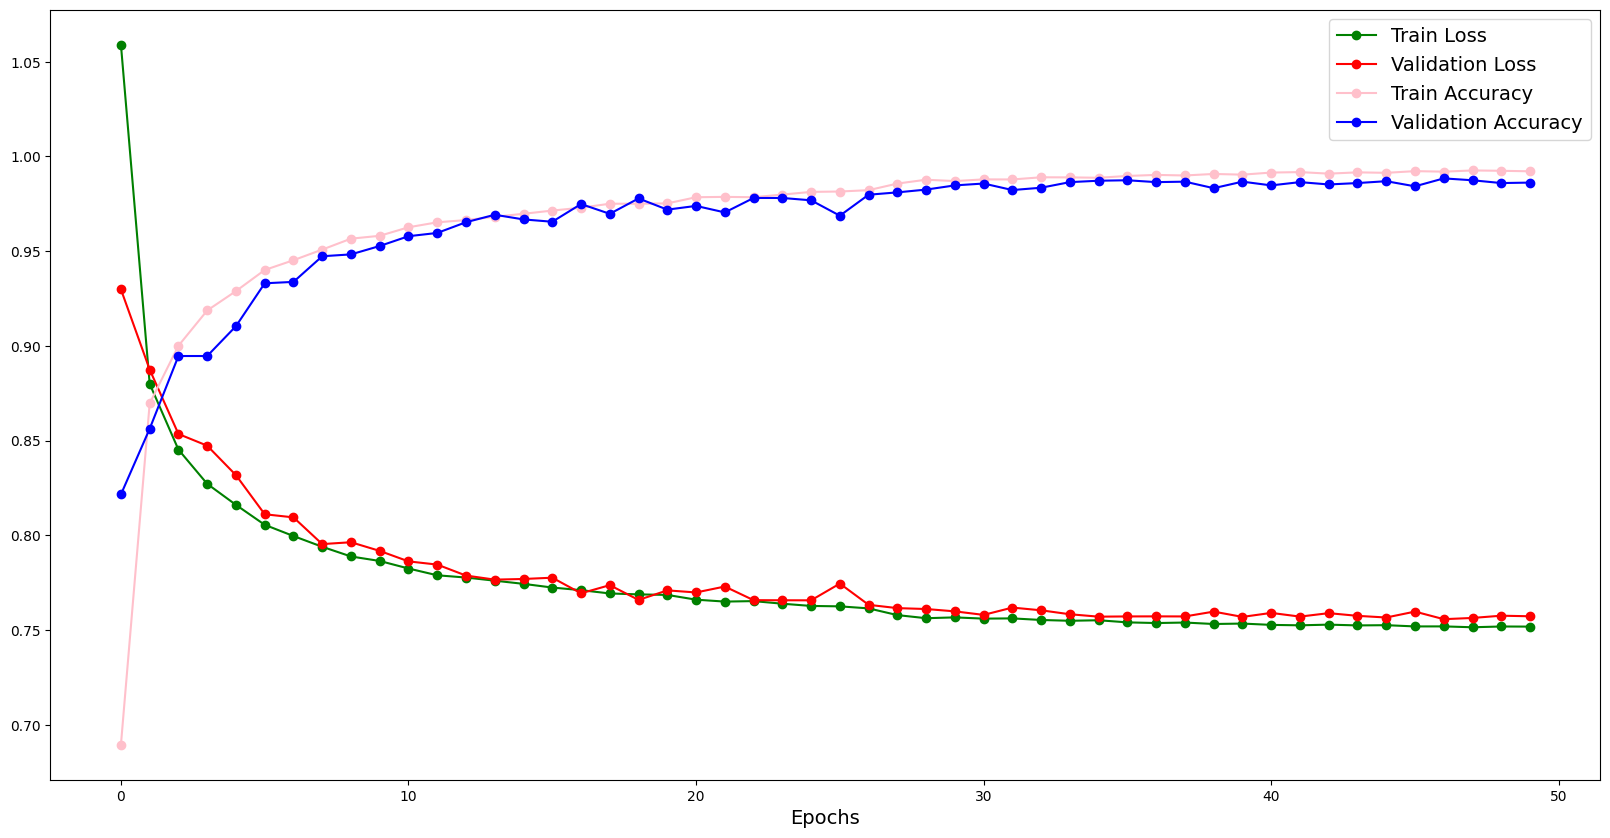

In [39]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [40]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3030
         1.0       0.99      0.97      0.98      3030
         2.0       0.99      0.99      0.99      1414
         3.0       0.94      0.98      0.96       606

    accuracy                           0.98      8080
   macro avg       0.98      0.98      0.98      8080
weighted avg       0.98      0.98      0.98      8080

